<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1704_feature_engineering_03_feature_selection_02_filter_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Descriptions of Filter Methods for Feature Selection

#### 1. **Chi-Squared Test (`chi2`)**
- **Description**: The Chi-Squared test measures the independence between two variables. In the context of feature selection, it evaluates how strongly each feature is associated with the target variable.
- **Application**: Suitable for categorical data. The test assumes that the features and the target variable are categorical and counts the occurrences of each category.
- **Strengths**: Simple to implement and computationally efficient.
- **Limitations**: Assumes independence between features, which may not hold in all cases.

#### 2. **ANOVA F-Test (`f_classif`)**
- **Description**: The ANOVA (Analysis of Variance) F-test measures the variance between groups relative to the variance within groups. For feature selection, it evaluates how significantly the mean of the feature varies across different classes of the target variable.
- **Application**: Suitable for continuous features and categorical targets. It compares the variance of the feature values between different target classes.
- **Strengths**: Effective for continuous data and can handle larger datasets.
- **Limitations**: Assumes normal distribution and homogeneity of variance, which may not always be true.

#### 3. **Mutual Information (`mutual_info_classif`)**
- **Description**: Mutual Information measures the mutual dependence between two variables. It quantifies the amount of information obtained about one variable through the other. In feature selection, it evaluates how much information about the target variable is provided by each feature.
- **Application**: Suitable for both continuous and categorical data. It can handle non-linear relationships between features and the target.
- **Strengths**: Does not assume any specific distribution and can capture complex dependencies.
- **Limitations**: Computationally intensive for large datasets, and the interpretation of mutual information values can be less straightforward.

### Usage Context
- **Chi-Squared Test**: Use when dealing with categorical features and target variables, such as when features represent different categories or levels.
- **ANOVA F-Test**: Use when features are continuous, and the target variable is categorical, such as in regression problems where you want to select features that best separate different classes.
- **Mutual Information**: Use when you want to capture both linear and non-linear relationships between features and the target variable, regardless of whether they are continuous or categorical.

These descriptions provide a clear understanding of when and why to use each method, highlighting their strengths and limitations to help in selecting the appropriate technique for your feature selection tasks.

## Baseline Performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, ThresholdClassifier, plot_selected_features
from loan_data_feature_engineering import RatioFeatures, BinningFeatures, SelectiveBinningFeaturesOneHot, CustomInteractionFeatures

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage', 'education']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = ['sex', 'marriage']
# Define the custom ordering for the 'education' variable as ordered category
education_order = [0, 1, 2, 3, 4, 5, 6]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('education_ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[education_order]))
        ]), ['education']),  # Treat education separately with ordinal encoding
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_columns)
    ])

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=5000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Train the classifier on the resampled data
classifier.fit(X_train_res, y_train_res)

# Predict and evaluate on the preprocessed test set
y_pred = classifier.predict(X_test_preprocessed)
baseline_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Initialize a dictionary to store the classification reports
experiment_results = {}
selected_features = {}

# Add the baseline report to the dictionary
experiment_results['baseline'] = baseline_report

# Define the path and filename for the JSON file
json_filename = 'classification_reports_filter_methods.json'

# Function to save the experiment results to a JSON file
def save_experiment_results(results, filename):
    with open(filename, 'w') as json_file:
        json.dump(results, json_file, indent=4)
    print(f'Experiment results saved to {filename}')

# Save the baseline report to the JSON file
save_experiment_results(experiment_results, json_filename)

              precision    recall  f1-score   support

           0       0.88      0.24      0.38      4673
           1       0.25      0.88      0.39      1327

    accuracy                           0.38      6000
   macro avg       0.56      0.56      0.38      6000
weighted avg       0.74      0.38      0.38      6000

Experiment results saved to classification_reports_filter_methods.json


## Feature Engineering Model

In [2]:
from loan_data_feature_engineering import RatioFeatures, BinningFeatures, SelectiveBinningFeaturesOneHot, CustomInteractionFeatures

# Convert the preprocessed training data back to DataFrame

# Get the feature names from the preprocessor
numeric_feature_names = numeric_features
ordinal_feature_names = ['education']  # Since it's now processed as an ordinal category
onehot_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns))

# Combine the feature names
all_feature_names = numeric_feature_names + ordinal_feature_names + onehot_feature_names

# Convert the preprocessed data to DataFrames with the correct feature names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Define your custom interaction pairs
interaction_pairs = [
    ('limit_bal', 'age'),
    ('limit_bal', 'pay_1'),
    ('limit_bal', 'pay_2'),
    ('bill_amt1', 'pay_amt1'),
    ('marriage_1', 'pay_1'),
    ('education_5', 'pay_1'),
    ('sex_2', 'pay_1'),
    ('marriage_1', 'pay_2'),
    ('sex_2', 'marriage_2'),
]

# Step 1: Apply Interaction Features First
interaction_pipeline = Pipeline(steps=[
    ('interaction', CustomInteractionFeatures(interaction_pairs=interaction_pairs))
])

# Step 2: Then Apply Feature Engineering Pipeline
features_to_bin = ['bill_amt1', 'pay_amt1', 'limit_bal']

feature_engineering_pipeline = Pipeline(steps=[
    ('ratio', RatioFeatures()),
    ('binning', SelectiveBinningFeaturesOneHot(features_to_bin, n_bins=5, encode='onehot', strategy='quantile'))
])

# Combine Interaction Pipeline with the Feature Engineering Pipeline
full_pipeline = Pipeline(steps=[
    ('interaction', interaction_pipeline),
    ('feature_engineering', feature_engineering_pipeline)
])

# Apply the full pipeline to the training data
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Apply SMOTE after feature engineering
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_fe, y_train)

# Now you can proceed with model training
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_res, y_train_res)

# Evaluate on the test set
y_pred_fe = classifier.predict(X_test_fe)
fe_report = classification_report(y_test, y_pred_fe, output_dict=True)
print(classification_report(y_test, y_pred_fe))

# Add the current experiment report to the dictionary
experiment_results['feature_engineering'] = fe_report

# Save the updated experiment results to the JSON file
save_experiment_results(experiment_results, json_filename)


              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4673
           1       0.44      0.62      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.74      0.75      6000

Experiment results saved to classification_reports_filter_methods.json


## Chi-Squared Test for Categorical Feature Selection

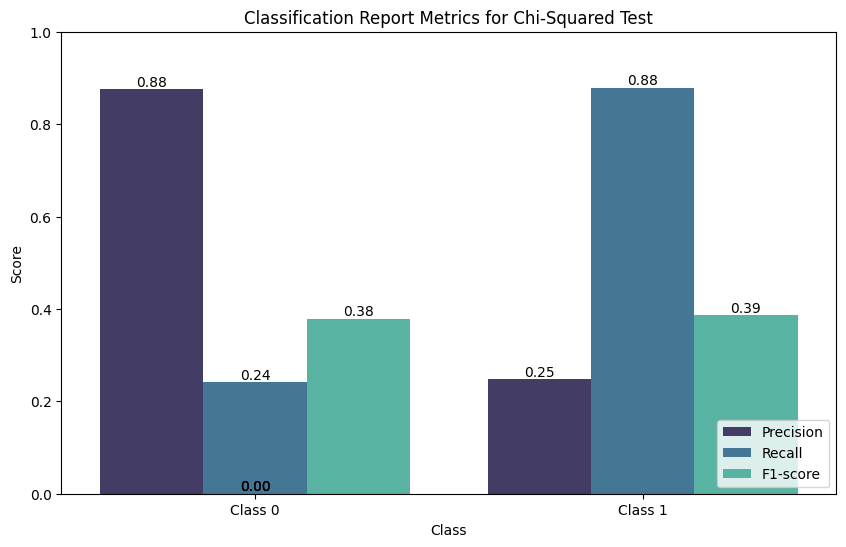

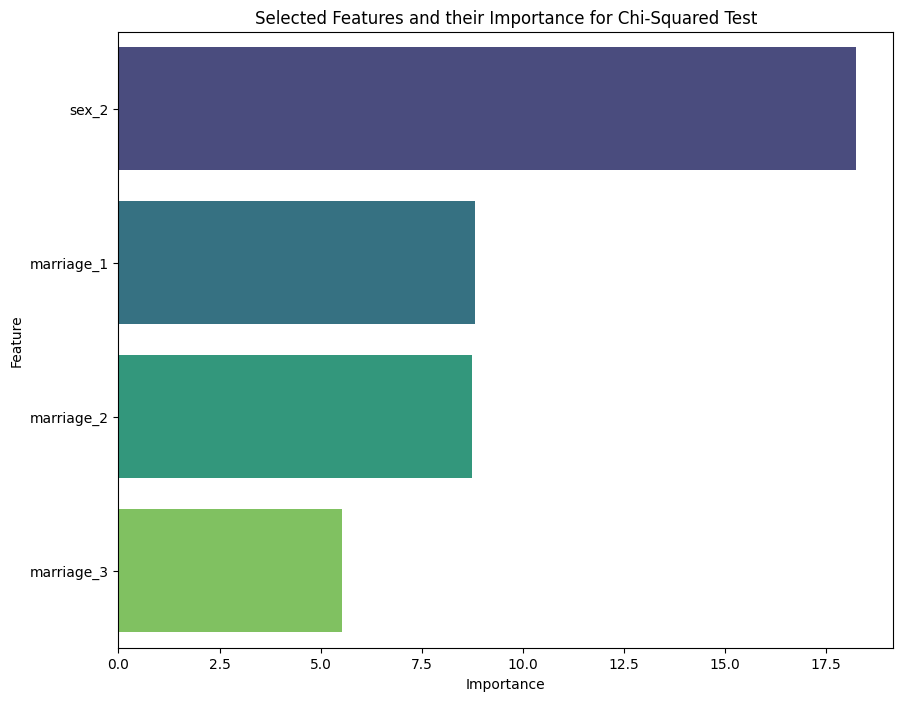

In [3]:
from sklearn.preprocessing import MaxAbsScaler, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import json

# Define custom order for the 'education' variable
education_order = [0, 1, 2, 3, 4, 5, 6]

# Dynamically set k for SelectKBest based on available features
onehot_feature_count = len(list(OneHotEncoder(drop='first').fit(X[categorical_columns]).get_feature_names_out(categorical_columns)))
k = min(onehot_feature_count, 5)  # Ensure k does not exceed the number of available features

# Updated preprocessor with ordinal preprocessing for 'education'
preprocessor_chi2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('education_ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[education_order]))
        ]), ['education']),  # Treat 'education' as an ordinal category
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first')),
            ('scaler', MaxAbsScaler()),  # Use MaxAbsScaler to ensure non-negative values for sparse input
            ('selectkbest', SelectKBest(chi2, k=k))  # Use dynamically determined k
        ]), categorical_columns)
    ])

# Preprocess the training data with chi2 selection
X_train_preprocessed = preprocessor_chi2.fit_transform(X_train, y_train)

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Preprocess the test data (no resampling here)
X_test_preprocessed = preprocessor_chi2.transform(X_test)

# Define the custom classifier to handle class-specific threshold
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Create a pipeline with preprocessing and classification
pipeline_chi2 = Pipeline(steps=[
    ('classifier', classifier)
])

# Train the model and evaluate
pipeline_chi2.fit(X_train_res, y_train_res)
y_pred_chi2 = pipeline_chi2.predict(X_test_preprocessed)
classification_report_chi2 = classification_report(y_test, y_pred_chi2, output_dict=True)

# Extract the selected feature names and their scores
selectkbest_chi2 = preprocessor_chi2.named_transformers_['cat'].named_steps['selectkbest']
selected_binary_features_chi2 = selectkbest_chi2.get_support()
feature_names_chi2 = preprocessor_chi2.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns)
selected_feature_names_chi2 = [feature_names_chi2[i] for i in range(len(feature_names_chi2)) if selected_binary_features_chi2[i]]
selected_feature_scores_chi2 = selectkbest_chi2.scores_[selected_binary_features_chi2]

# Create a dictionary of selected features and their scores
selected_features_chi2 = dict(zip(selected_feature_names_chi2, selected_feature_scores_chi2))

# Sort the selected features by their scores
sorted_selected_features_chi2 = dict(sorted(selected_features_chi2.items(), key=lambda item: item[1], reverse=True))

# Add the classification report and selected features to the dictionaries
experiment_results['Chi-Squared Test'] = classification_report_chi2
selected_features['Chi-Squared Test'] = sorted_selected_features_chi2

# Save the accumulated results and selected features to files
def save_to_file(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

save_to_file('classification_reports_filter_methods.json', experiment_results)
save_to_file('selected_features_filter_methods.json', selected_features)

# Optional: Plot the classification report metrics and sorted selected features
plot_classification_report_metrics(classification_report_chi2, 'Chi-Squared Test')
plot_selected_features(sorted_selected_features_chi2, 'Chi-Squared Test')


## ANOVA for Numeric Feature Selection

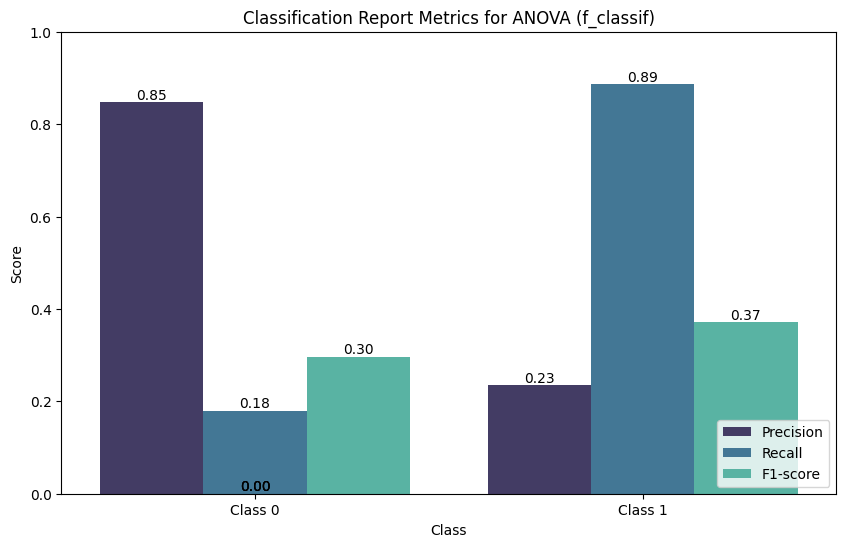

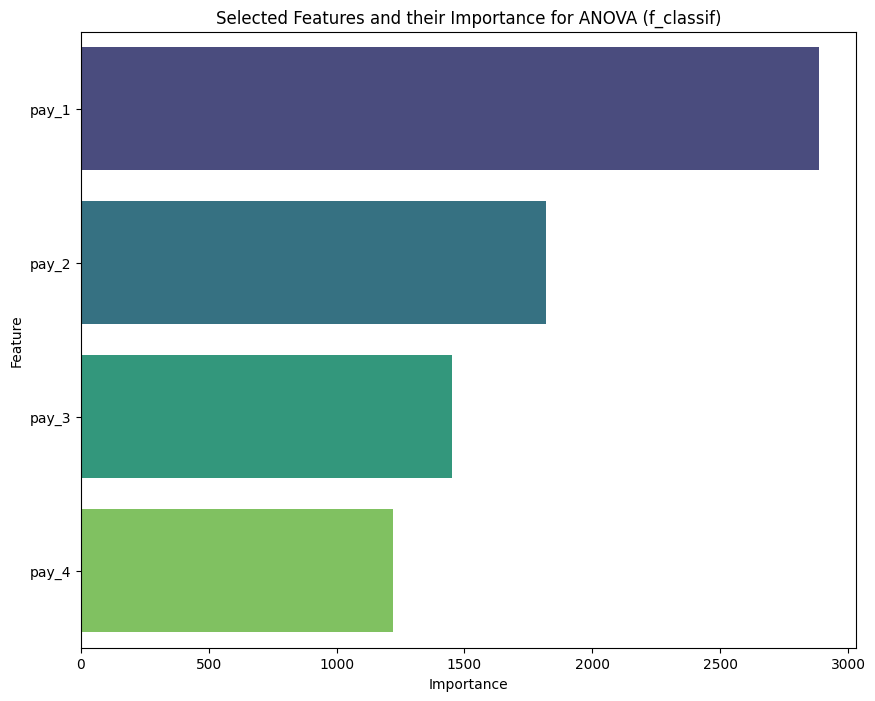

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

# Dynamically set k for SelectKBest based on available features
onehot_feature_count = len(list(OneHotEncoder(drop='first').fit(X[categorical_columns]).get_feature_names_out(categorical_columns)))
k = min(onehot_feature_count, 5)  # Ensure k does not exceed the number of available features

# Updated preprocessor with ANOVA feature selection for numeric features
preprocessor_anova = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('selectkbest', SelectKBest(f_classif, k=k))  # Apply ANOVA feature selection for numeric features
        ]), numeric_features),
        ('education_ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[education_order]))
        ]), ['education']),  # Process 'education' as an ordinal category
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first')),
            ('scaler', MaxAbsScaler())
        ]), categorical_columns)
    ])

# Preprocess the training data with ANOVA selection
X_train_preprocessed = preprocessor_anova.fit_transform(X_train, y_train)

# Apply SMOTE after preprocessing
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Preprocess the test data (no resampling here)
X_test_preprocessed = preprocessor_anova.transform(X_test)

# Train the ANOVA classifier
pipeline_anova = Pipeline(steps=[
    ('classifier', classifier)
])
pipeline_anova.fit(X_train_res, y_train_res)
y_pred_anova = pipeline_anova.predict(X_test_preprocessed)

# Evaluate and store results
classification_report_anova = classification_report(y_test, y_pred_anova, output_dict=True)

# Extract the selected numeric feature names and their scores
selectkbest_anova = preprocessor_anova.named_transformers_['num'].named_steps['selectkbest']
selected_numeric_features_anova = selectkbest_anova.get_support()
selected_numeric_feature_names = [numeric_features[i] for i in range(len(numeric_features)) if selected_numeric_features_anova[i]]
selected_numeric_feature_scores = selectkbest_anova.scores_[selected_numeric_features_anova]

# Create a dictionary of selected features and their scores
selected_features_anova = dict(zip(selected_numeric_feature_names, selected_numeric_feature_scores))

# Sort the selected features by their scores
sorted_selected_features_anova = dict(sorted(selected_features_anova.items(), key=lambda item: item[1], reverse=True))

# Add the classification report and selected features to the dictionaries
experiment_results['ANOVA (f_classif)'] = classification_report_anova
selected_features['ANOVA (f_classif)'] = sorted_selected_features_anova

# Save the updated experiment results to the JSON file
save_to_file('classification_reports_filter_methods.json', experiment_results)
save_to_file('selected_features_filter_methods.json', selected_features)

# Optional: Plot the classification report metrics and sorted selected features
plot_classification_report_metrics(classification_report_anova, 'ANOVA (f_classif)')
plot_selected_features(sorted_selected_features_anova, 'ANOVA (f_classif)')


## Combining Chi-Square and ANOVA Selected Features

In [11]:
# plot_selected_features(final_selected_features, 'Combined Features (Chi-Square + ANOVA)')
preprocessor_chi2.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns)

array(['sex_2', 'marriage_1', 'marriage_2', 'marriage_3'], dtype=object)

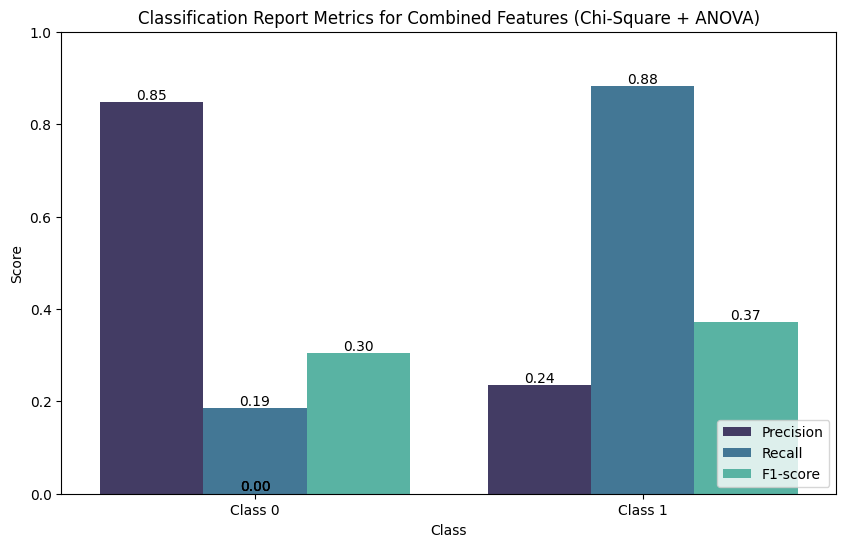

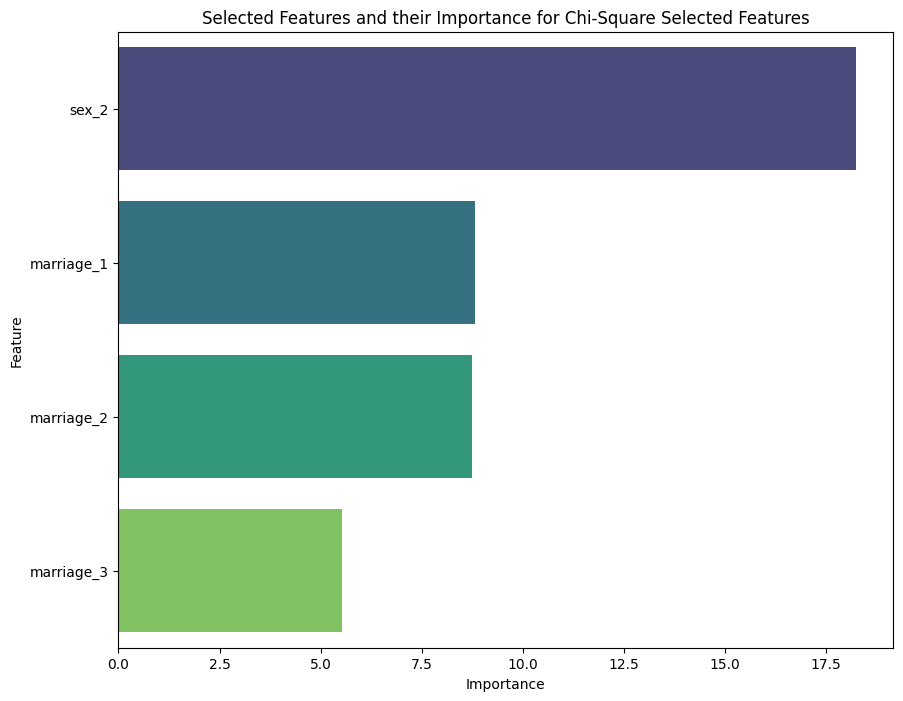

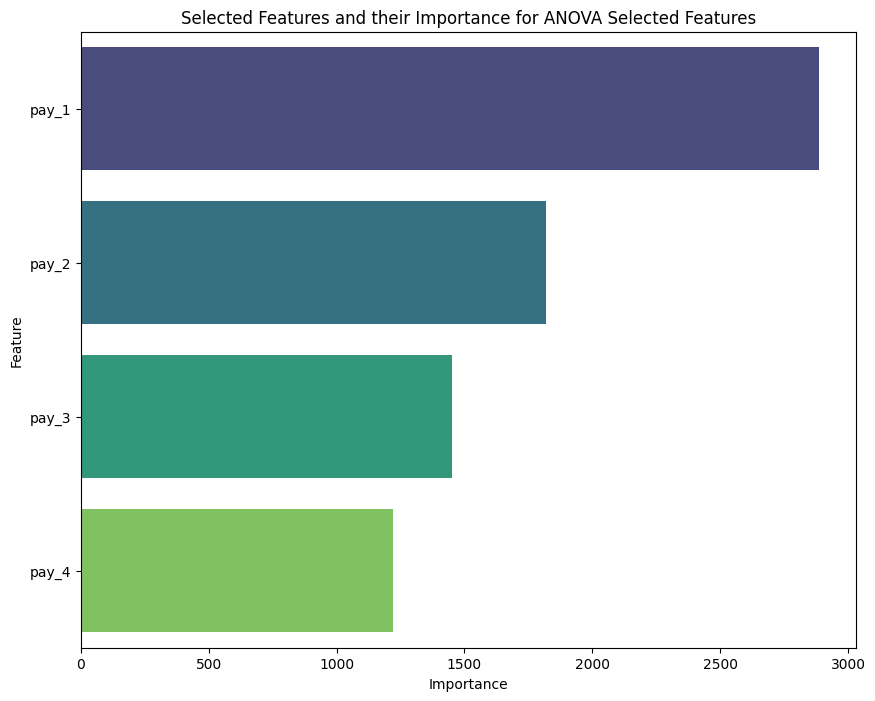

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report
import json

# Extract selected feature names after encoding
selected_categorical_features = selected_feature_names_chi2  # From Chi-Square selection
selected_numeric_features = selected_numeric_feature_names  # From ANOVA selection

# Extract encoded feature names after fitting the OneHotEncoder
encoded_feature_names = preprocessor_chi2.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns)

# Rebuild the combined feature list with the correct encoded feature names
final_selected_features = selected_numeric_features + [
    feature for feature in encoded_feature_names if feature in selected_categorical_features
]

# Create a new preprocessor to include only the selected features
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), selected_numeric_features),  # Only selected numeric features
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_columns)  # Apply full categorical pipeline again
    ])

# Fit the final preprocessor and transform the data
X_train_preprocessed_final = final_preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed_final = final_preprocessor.transform(X_test)

# Apply SMOTE after preprocessing
X_train_res_final, y_train_res_final = smote.fit_resample(X_train_preprocessed_final, y_train)

# Train the model using the combined feature set
pipeline_combined = Pipeline(steps=[
    ('classifier', classifier)
])
pipeline_combined.fit(X_train_res_final, y_train_res_final)
y_pred_combined = pipeline_combined.predict(X_test_preprocessed_final)

# Evaluate and store results
classification_report_combined = classification_report(y_test, y_pred_combined, output_dict=True)

# Add the classification report for the combined feature set to the results dictionary
experiment_results['Combined Features (Chi-Square + ANOVA)'] = classification_report_combined

# Save the updated experiment results to the JSON file
save_to_file('classification_reports_filter_methods.json', experiment_results)

# Optional: Plot the classification report metrics for the combined feature set
plot_classification_report_metrics(classification_report_combined, 'Combined Features (Chi-Square + ANOVA)')

# plot selected features
# Plot the combined selected features
plot_selected_features(sorted_selected_features_chi2, 'Chi-Square Selected Features')
plot_selected_features(sorted_selected_features_anova, 'ANOVA Selected Features')


#### Feature Engineering Script


In [4]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ------ Ratio Features ------ #

class RatioFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['bill_ratio'] = X['bill_amt1'] / X['limit_bal']
        X['pay_ratio'] = X['pay_amt1'] / X['limit_bal']
        X['age_income_ratio'] = X['age'] / X['limit_bal']
        return X

# ----- Binning Features ------ #

class BinningFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=5, encode='ordinal', strategy='quantile'):
        # Explicitly store the parameters as class attributes
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)

    def fit(self, X, y=None):
        self.binner.fit(X)
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X)
        return pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.feature_names_in_])


class SelectiveBinningFeaturesOrdinal(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='ordinal', strategy='quantile'):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        self.other_features = None

    def fit(self, X, y=None):
        # Fit only the features that need binning
        self.binner.fit(X[self.features_to_bin])
        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])
        X_binned_df = pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.features_to_bin])
        return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)


class SelectiveBinningFeaturesOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='onehot', strategy='quantile'):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        self.onehot_encoder = OneHotEncoder(sparse_output=False)
        self.other_features = None
        self.encode = encode

    def fit(self, X, y=None):
        # Fit only the features that need binning
        self.binner.fit(X[self.features_to_bin])
        X_binned = self.binner.transform(X[self.features_to_bin])

        # Fit the one-hot encoder if needed
        if self.encode == 'onehot':
            self.onehot_encoder.fit(X_binned)

        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])

        # Apply one-hot encoding if needed
        if self.encode == 'onehot':
            X_binned = self.onehot_encoder.transform(X_binned)
            bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(X_binned.shape[1] // len(self.features_to_bin))]
        else:
            bin_columns = [f'{col}_binned' for col in self.features_to_bin]

        X_binned_df = pd.DataFrame(X_binned, columns=bin_columns)
        return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)


# ----- Interaction Features ------ #

class TargetedInteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs=None, degree=2, interaction_only=True, include_bias=False):
        self.degree = degree
        self.interaction_only = interaction_only
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, interaction_only=self.interaction_only, include_bias=self.include_bias)
        self.feature_names_in_ = None
        self.interaction_pairs = interaction_pairs  # List of tuples specifying which pairs to interact

    def fit(self, X, y=None):
        if self.interaction_pairs is None:
            self.poly.fit(X)
            self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        else:
            # Limit the features to the interaction pairs
            interaction_columns = [pair[0] for pair in self.interaction_pairs] + [pair[1] for pair in self.interaction_pairs]
            X_selected = X[interaction_columns]
            self.poly.fit(X_selected)
            self.feature_names_in_ = X_selected.columns
        return self

    def transform(self, X):
        if self.interaction_pairs is None:
            X_poly = self.poly.transform(X)
            return pd.DataFrame(X_poly, columns=self.poly.get_feature_names_out(self.feature_names_in_))
        else:
            # Create interaction features for the selected pairs only
            interaction_data = pd.DataFrame(index=X.index)
            for pair in self.interaction_pairs:
                interaction_term = X[pair[0]] * X[pair[1]]
                interaction_data[f"{pair[0]}_{pair[1]}"] = interaction_term
            return interaction_data


class CustomInteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs):
        self.interaction_pairs = interaction_pairs

    def fit(self, X, y=None):
        # Store the column names from the DataFrame
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        # Debug: Print the columns available in the DataFrame
        # print("Columns available for interaction:", X.columns)

        interaction_data = pd.DataFrame(index=X.index)
        for pair in self.interaction_pairs:
            # Check if both columns in the pair exist in the DataFrame
            if pair[0] in X.columns and pair[1] in X.columns:
                interaction_data[f"{pair[0]}_{pair[1]}"] = X[pair[0]] * X[pair[1]]
            else:
                # Print a warning with more detail if columns are missing
                missing_columns = [col for col in pair if col not in X.columns]
                # print(f"Warning: Columns {missing_columns} from pair {pair} not found in DataFrame columns.")

        # Return the original DataFrame combined with the interaction terms
        return pd.concat([X, interaction_data], axis=1)


# ----- Plot Feature Groups ------ #

def plot_feature_groups(dataframe, feature_groups, hue):
    """
    Plot pairplots for groups of features with color coding by a categorical variable.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the features.
    feature_groups (dict): A dictionary where keys are group names and values are lists of feature names.
    hue (str): The name of the categorical column to color by.
    """
    for group_name, features in feature_groups.items():
        sns.pairplot(dataframe[features + [hue]], hue=hue, palette='magma')
        plt.suptitle(f"Pairplot of {group_name} Features colored by {hue}", y=1.02)
        plt.show()


#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

'''

# Write the script to a file
with open("loan_data_feature_engineering.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_feature_engineering.py")

# Reload script to make functions available for use
import importlib
import loan_data_feature_engineering
importlib.reload(loan_data_feature_engineering)
from loan_data_feature_engineering import *

Script successfully written to loan_data_feature_engineering.py


#### Data Utils Script

In [5]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Custom Classifier   --------#

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


# #--------   Plot Classification Report  --------#

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

def plot_classification_report_thresholds(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
